# Simple autoencoder

This is a very simple autoencoder based on a MLP architecture.

In [17]:
import os
import sys

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets, transforms
from torchsummary import summary
from torchvision.utils import save_image

import numpy as np
from matplotlib import pyplot as plt

In [2]:
if not os.path.exists('./simple_autoencoder'):
    os.mkdir('./simple_autoencoder')


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [3]:
input_size= (1,784,)
num_epochs = 10
batch_size = 128
learning_rate = 1e-3

dataloader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)

In [37]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12) )
            #nn.ReLU(True), 
            #nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            #nn.Linear(3, 12),
            #nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x 

In [12]:
model = autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [13]:
summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]         100,480
              ReLU-2               [-1, 1, 128]               0
            Linear-3                [-1, 1, 64]           8,256
              ReLU-4                [-1, 1, 64]               0
            Linear-5                [-1, 1, 12]             780
            Linear-6                [-1, 1, 64]             832
              ReLU-7                [-1, 1, 64]               0
            Linear-8               [-1, 1, 128]           8,320
              ReLU-9               [-1, 1, 128]               0
           Linear-10               [-1, 1, 784]         101,136
             Tanh-11               [-1, 1, 784]               0
Total params: 219,804
Trainable params: 219,804
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [14]:
Loss = []
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        
        output = model(img)
        loss = criterion(output, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    Loss.append(loss.item())
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        pic = to_img(output.data)
        save_image(pic, './simple_autoencoder/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './simple_autoencoder/simple_autoencoder.pt')

epoch [1/10], loss:0.4677
epoch [2/10], loss:0.4469
epoch [3/10], loss:0.4450
epoch [4/10], loss:0.4255
epoch [5/10], loss:0.4288
epoch [6/10], loss:0.4124
epoch [7/10], loss:0.4491
epoch [8/10], loss:0.4028
epoch [9/10], loss:0.4005
epoch [10/10], loss:0.4067


In [15]:
model.load_state_dict(torch.load('./simple_autoencoder/simple_autoencoder.pt'))
model.eval()

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Tanh()
  )
)

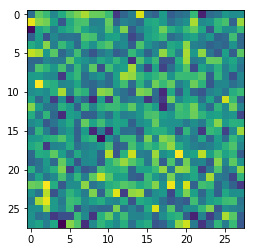

In [21]:
x = torch.randn(1,784)
plt.imshow(np.reshape(x,(28,28)))
plt.show()

In [22]:
output = model(x).detach().numpy()

# Question

- Guess what the output will look like.
- Can you imagine a theoretical explanation?
- Can you imagine how to test for it?

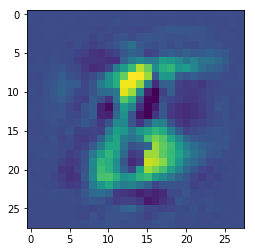

In [23]:
plt.imshow(np.reshape(output,(28,28)))
plt.show()

In [49]:
from matplotlib import pyplot as plt
plt.plot(Loss,'-bo')
plt.show()

# Exercise

Discussion in class of the points first.

- Why the loss in this model does not change much? Inspect the samples saved in './simple_autoencoder', they are terrible.
- How can this model be improved? Experiment on this a little bit. (Maybe you want to change the architecure a little bit?)
- Extract the code (a,b) of two images of your choice
- Decode a generic code given as input, in particular the codes a,b. Visualize the results.
- Transverse the *latent space* of the bottleneck layer from a to b.
  More precisely define a sequence of codes
  
$$
c = \lambda b + (1-\lambda)a, \;\;\; \lambda = [0,\dots,1]
$$

  and see for each one the decoded images (do it in N steps, where N is your choice).

In [29]:
inputs,labels = next(iter(dataloader))
output = model(inputs.view(inputs.shape[0],-1)).detach().numpy()

In [30]:
inputs.shape

torch.Size([128, 1, 28, 28])

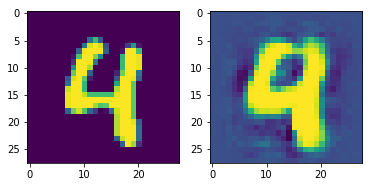

In [36]:
idx=0
plt.subplot(121)
plt.imshow(np.reshape(inputs[idx],(28,28)))
plt.subplot(122)
plt.imshow(np.reshape(output[idx],(28,28)))
plt.show()